# **Laboratorio 4 RNN - SIS421**
Arancibia Aguilar Daniel Andree

Ingeniería en Ciencias de la Computación


# **Arreglo del dataset**
Usare el dataset de la pagina https://datos.gob.es/en/catalogo/l02000008-calidad-del-agua-de-las-fuentes-naturales

Este dataset está incompleto asi que lo completare con pandas

In [13]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Leer el archivo CSV
file_path = 'E:/LAB4SIS421/CALIDAD_DEL_AGUA.csv'
df = pd.read_csv(file_path)

# Definir las columnas a modificar
columns_to_modify = ['Dureza Total', 'Hierro Total', 'Cloruros', 'Alcalinidad', 'Sulfatos', 'Nitratos', 'Resultados del IRCA por Muestra']

# Función para rellenar valores vacíos o ceros con valores aleatorios en el rango del promedio ± 3
def fill_missing_values(column):
    # Calcular el promedio de la columna, ignorando los ceros y NaN
    mean = column[column != 0].mean()
    if np.isnan(mean):
        return column  # Si no hay valores válidos para calcular el promedio, retornamos la columna original
    
    # Generar valores aleatorios entre (mean - 3) y (mean + 3)
    def random_fill(val):
        if pd.isna(val) or val == 0:
            return np.random.uniform(mean - 3, mean + 3)
        else:
            return val
    
    return column.apply(random_fill)

# Aplicar la función solo a las columnas específicas
for column in columns_to_modify:
    if column in df.columns:
        df[column] = fill_missing_values(df[column])

# Definir las columnas de fecha y hora a modificar
date_columns = ['Fecha de Toma de Muestra', 'Hora de Toma de Muestra', 'Fecha de Entrega al Laboratorio']

# Fecha de inicio
start_date = datetime(2019, 1, 1)

# Calcular el número total de filas en el DataFrame
num_rows = len(df)

# Generar fechas continuas
def generate_continuous_dates(start_date, num_days):
    return [start_date + timedelta(days=i) for i in range(num_days)]

# Generar horas aleatorias
def generate_random_times(num_rows):
    return [datetime.strptime(f'{random.randint(0, 23):02}:{random.randint(0, 59):02}', '%H:%M').time() for _ in range(num_rows)]

# Crear una lista de fechas continuas y horas aleatorias
date_list = generate_continuous_dates(start_date, num_rows)
time_list = generate_random_times(num_rows)

# Reemplazar valores en las columnas de fecha y hora
for column in date_columns:
    if column in df.columns:
        if 'Hora' in column:
            # Para la columna de hora, asignar una hora aleatoria
            df[column] = time_list
        else:
            # Para las columnas de fecha, asignar una fecha continua
            df[column] = [date.strftime('%Y-%m-%d') for date in date_list]

# Guardar el DataFrame modificado en un nuevo archivo CSV
output_file_path = 'E:/LAB4SIS421/CALIDAD_DEL_AGUA_SEMISINTETICO.csv'
df.to_csv(output_file_path, index=False)

print(f"El archivo modificado ha sido guardado en {output_file_path}")


El archivo modificado ha sido guardado en E:/LAB4SIS421/CALIDAD_DEL_AGUA_SEMISINTETICO3.csv


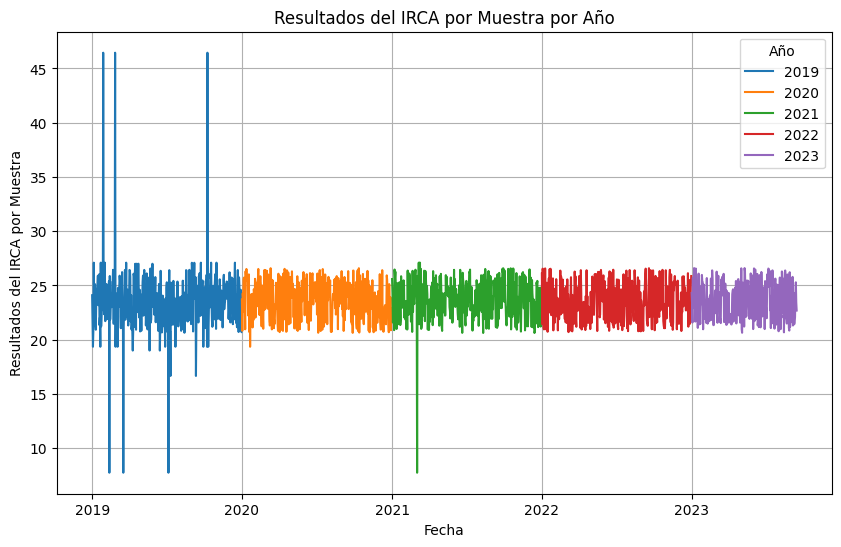

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
file_path = r'E:\LAB4SIS421\CALIDAD_DEL_AGUA_SEMISINTETICO.csv'
df = pd.read_csv(file_path)

# Convertir la columna de fecha a tipo datetime
df['Fecha de Toma de Muestra'] = pd.to_datetime(df['Fecha de Toma de Muestra'], format='%m/%d/%Y')

# Extraer el año de la fecha de toma de muestra
df['Año'] = df['Fecha de Toma de Muestra'].dt.year

# Graficar la columna 'Resultados del IRCA por Muestra' por año
plt.figure(figsize=(10, 6))
for year in df['Año'].unique():
    # Filtrar los datos por año
    yearly_data = df[df['Año'] == year]
    plt.plot(yearly_data['Fecha de Toma de Muestra'], yearly_data['Resultados del IRCA por Muestra'], label=str(year))

plt.title('Resultados del IRCA por Muestra por Año')
plt.xlabel('Fecha')
plt.ylabel('Resultados del IRCA por Muestra')
plt.legend(title='Año')
plt.grid(True)
plt.show()


# **LSTM**

Epoch [10/100], Loss: 0.0983, Test Loss: 0.0819
Epoch [20/100], Loss: 0.0061, Test Loss: 0.0019
Epoch [30/100], Loss: 0.0074, Test Loss: 0.0028
Epoch [40/100], Loss: 0.0082, Test Loss: 0.0048
Epoch [50/100], Loss: 0.0064, Test Loss: 0.0026
Epoch [60/100], Loss: 0.0055, Test Loss: 0.0019
Epoch [70/100], Loss: 0.0059, Test Loss: 0.0024
Epoch [80/100], Loss: 0.0057, Test Loss: 0.0022
Epoch [90/100], Loss: 0.0056, Test Loss: 0.0020
Epoch [100/100], Loss: 0.0056, Test Loss: 0.0022


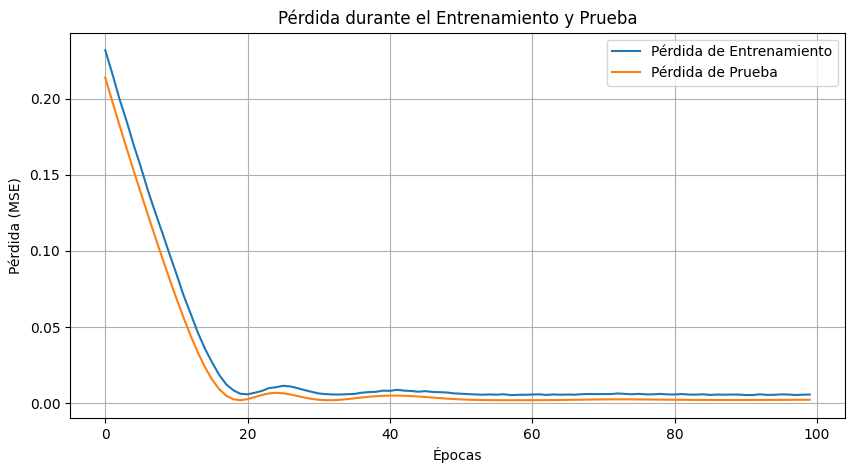

MSE en Entrenamiento: 0.0037
MSE en Prueba: 0.0022


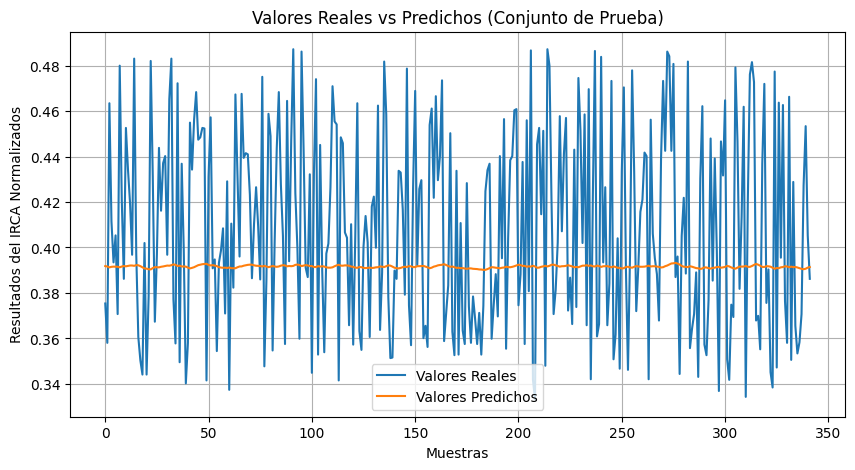

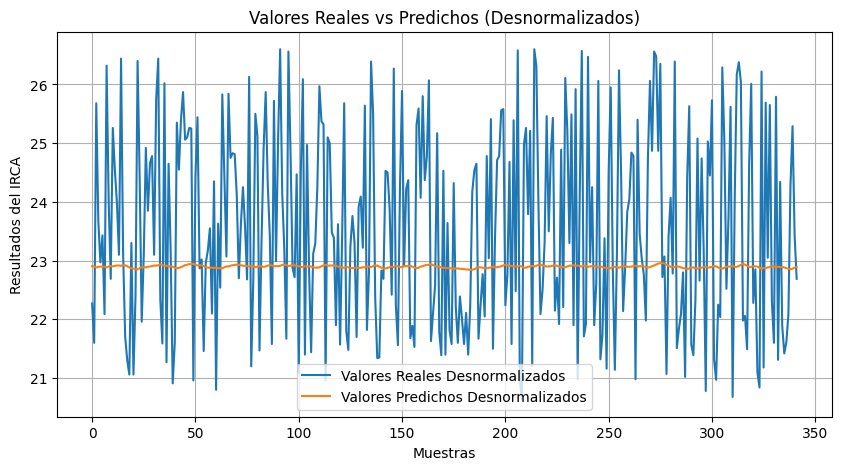

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.optim import Adam

# Cargar el dataset
file_path = r'E:\LAB4SIS421\CALIDAD_DEL_AGUA_SEMISINTETICO.csv'
df = pd.read_csv(file_path)

# Convertir la columna de fecha a tipo datetime
df['Fecha de Toma de Muestra'] = pd.to_datetime(df['Fecha de Toma de Muestra'], format='%m/%d/%Y')

# Extraer solo la columna de 'Resultados del IRCA por Muestra' y las fechas
data = df[['Fecha de Toma de Muestra', 'Resultados del IRCA por Muestra']].copy()

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
data['Resultados del IRCA por Muestra'] = scaler.fit_transform(data[['Resultados del IRCA por Muestra']])

# Convertir los datos en formato adecuado para LSTM (secuencia de tiempo)
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Definir longitud de la secuencia
SEQ_LENGTH = 10
X, y = create_sequences(data['Resultados del IRCA por Muestra'].values, SEQ_LENGTH)

# Convertir los datos a tensores
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Agregar una dimensión extra para LSTM
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Separar los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Definir el modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)  # Regularización

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Tomar la última salida
        out = self.dropout(out)
        return self.fc(out)

# Parámetros del modelo
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Definir la función de pérdida y el optimizador (con regularización L2)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Regularización L2 incluida

# Entrenar el modelo
EPOCHS = 100
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output_train = model(X_train)
    loss_train = criterion(output_train, y_train)
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        output_test = model(X_test)
        loss_test = criterion(output_test, y_test)
    
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(test_losses, label='Pérdida de Prueba')
plt.title('Pérdida durante el Entrenamiento y Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Predicción y cálculo del error cuadrático medio
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    
mse_train = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
mse_test = mean_squared_error(y_test.numpy(), y_test_pred.numpy())

print(f'MSE en Entrenamiento: {mse_train:.4f}')
print(f'MSE en Prueba: {mse_test:.4f}')

# Graficar valores reales vs predichos para el conjunto de prueba
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label='Valores Reales')
plt.plot(y_test_pred.numpy(), label='Valores Predichos')
plt.title('Valores Reales vs Predichos (Conjunto de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Resultados del IRCA Normalizados')
plt.legend()
plt.grid(True)
plt.show()

# Desnormalizar los valores predichos para graficar (si es necesario)
y_test_denorm = scaler.inverse_transform(y_test.numpy())
y_test_pred_denorm = scaler.inverse_transform(y_test_pred.numpy())

# Graficar los valores desnormalizados (opcionales)
plt.figure(figsize=(10, 5))
plt.plot(y_test_denorm, label='Valores Reales Desnormalizados')
plt.plot(y_test_pred_denorm, label='Valores Predichos Desnormalizados')
plt.title('Valores Reales vs Predichos (Desnormalizados)')
plt.xlabel('Muestras')
plt.ylabel('Resultados del IRCA')
plt.legend()
plt.grid(True)
plt.show()


# **GRU**

Epoch [10/100], Loss: 0.0165, Test Loss: 0.0099
Epoch [20/100], Loss: 0.0079, Test Loss: 0.0043
Epoch [30/100], Loss: 0.0064, Test Loss: 0.0019
Epoch [40/100], Loss: 0.0060, Test Loss: 0.0019
Epoch [50/100], Loss: 0.0062, Test Loss: 0.0022
Epoch [60/100], Loss: 0.0056, Test Loss: 0.0019
Epoch [70/100], Loss: 0.0053, Test Loss: 0.0019
Epoch [80/100], Loss: 0.0056, Test Loss: 0.0019
Epoch [90/100], Loss: 0.0048, Test Loss: 0.0019
Epoch [100/100], Loss: 0.0052, Test Loss: 0.0019


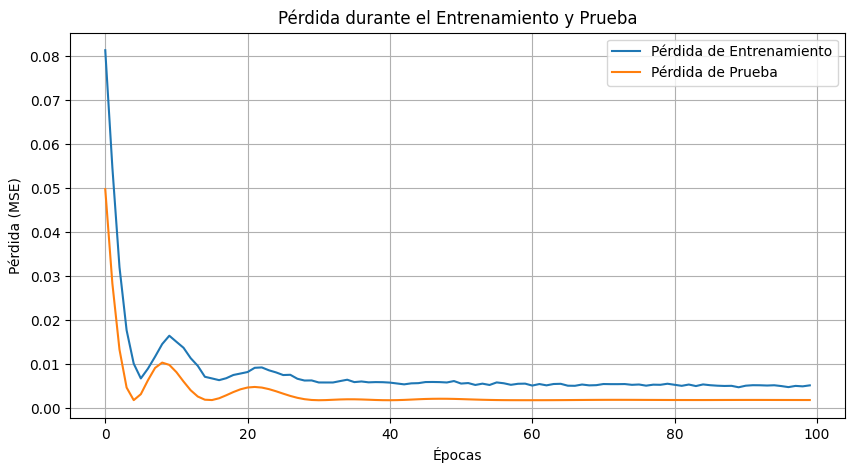

MSE en Entrenamiento: 0.0035
MSE en Prueba: 0.0019


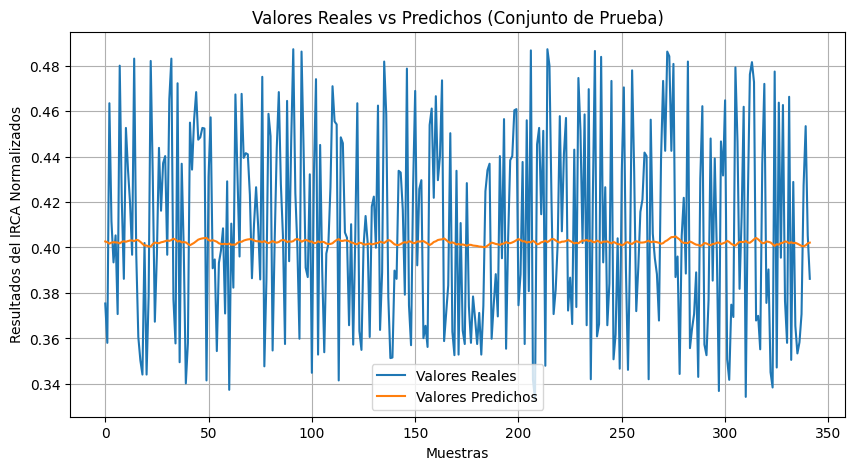

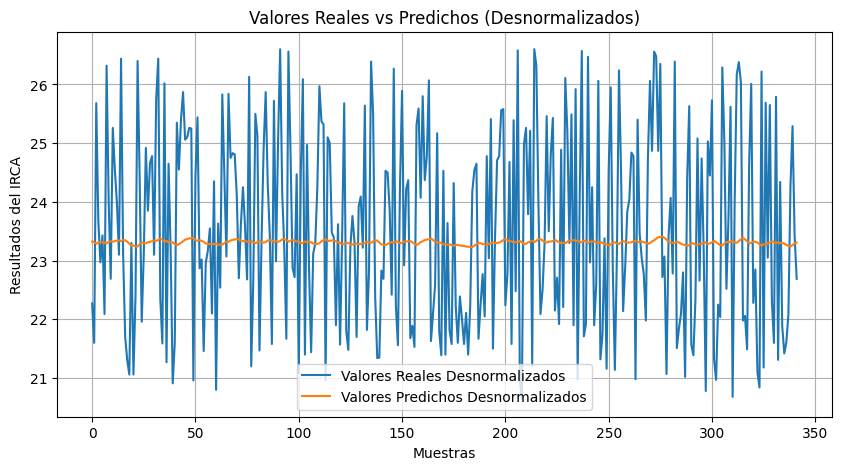

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.optim import Adam

# Cargar el dataset
file_path = r'E:\LAB4SIS421\CALIDAD_DEL_AGUA_SEMISINTETICO.csv'
df = pd.read_csv(file_path)

# Convertir la columna de fecha a tipo datetime
df['Fecha de Toma de Muestra'] = pd.to_datetime(df['Fecha de Toma de Muestra'], format='%m/%d/%Y')

# Extraer solo la columna de 'Resultados del IRCA por Muestra' y las fechas
data = df[['Fecha de Toma de Muestra', 'Resultados del IRCA por Muestra']].copy()

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
data['Resultados del IRCA por Muestra'] = scaler.fit_transform(data[['Resultados del IRCA por Muestra']])

# Convertir los datos en formato adecuado para GRU (secuencia de tiempo)
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Definir longitud de la secuencia
SEQ_LENGTH = 10
X, y = create_sequences(data['Resultados del IRCA por Muestra'].values, SEQ_LENGTH)

# Convertir los datos a tensores
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Agregar una dimensión extra para GRU
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Separar los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# Definir el modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)  # Regularización

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = gru_out[:, -1, :]  # Tomar la última salida
        out = self.dropout(out)
        return self.fc(out)

# Parámetros del modelo
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2

model = GRUModel(input_size, hidden_size, output_size, num_layers)

# Definir la función de pérdida y el optimizador (con regularización L2)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Regularización L2 incluida

# Entrenar el modelo
EPOCHS = 100
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    output_train = model(X_train)
    loss_train = criterion(output_train, y_train)
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        output_test = model(X_test)
        loss_test = criterion(output_test, y_test)
    
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}')

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(test_losses, label='Pérdida de Prueba')
plt.title('Pérdida durante el Entrenamiento y Prueba')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Predicción y cálculo del error cuadrático medio
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    
mse_train = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
mse_test = mean_squared_error(y_test.numpy(), y_test_pred.numpy())

print(f'MSE en Entrenamiento: {mse_train:.4f}')
print(f'MSE en Prueba: {mse_test:.4f}')

# Graficar valores reales vs predichos para el conjunto de prueba
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label='Valores Reales')
plt.plot(y_test_pred.numpy(), label='Valores Predichos')
plt.title('Valores Reales vs Predichos (Conjunto de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Resultados del IRCA Normalizados')
plt.legend()
plt.grid(True)
plt.show()

# Desnormalizar los valores predichos para graficar (si es necesario)
y_test_denorm = scaler.inverse_transform(y_test.numpy())
y_test_pred_denorm = scaler.inverse_transform(y_test_pred.numpy())

# Graficar los valores desnormalizados (opcionales)
plt.figure(figsize=(10, 5))
plt.plot(y_test_denorm, label='Valores Reales Desnormalizados')
plt.plot(y_test_pred_denorm, label='Valores Predichos Desnormalizados')
plt.title('Valores Reales vs Predichos (Desnormalizados)')
plt.xlabel('Muestras')
plt.ylabel('Resultados del IRCA')
plt.legend()
plt.grid(True)
plt.show()
